In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [1]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0(если это не так, то требуется перезагрузить ноутбук)
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


5.3.0


In [2]:
# Подгружаю свой google disk, куда буду скачивать датасет и сохранять веса натренированных моделей
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
# Загружаю с локальной машины токен авторизации (kaggle.json - скачивается с kaggle в разделе Account - Create New API Token). 
# Это нужно для сабмита на kaggle сразу из google colab.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"postas1234","key":"0febf7f3e350308d9911328b68c29cc6"}'}

In [3]:
# Установка пакета kaggle, mkdir - создание папки .kaggle, cp - копирование файла kaggle.json,
# chmod 600 - установка прав доступа (600 - можно читать и писать)
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
# Скачиваем датасет с kaggle по ссылке в папку "/content/gdrive/My Drive/simpsons/data/simpsons.zip"
# Можно использовать команду !wget, но использовал библиотеку request
import requests  
file_url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/17804/848527/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1577910911&Signature=U2RklEx9UNv8eZWlUQCp39lGv0Q2E0g0N2WJHdxLsfGTChjG%2BGPOP3ObKgYRkOyjEKx12sSqRdLbs2kMMpzU9Jc6mzYU3aRBS52yagbwbWY9snc4uvKwLjpvCL8cI9gHZl17coi4pDgcDRmR6QITr4X2GuMQj9V45k8eW%2FZRrSMtUgLDGXHHFezaDQzMzzmEojPcgFDKJNOUNGgBhXPt%2BPtiJAIvGJ0kyfO%2FXeYv2MsPWcOkE%2FxiU9hxUN5G45p53TGUpPahoOc8nawQLJYaFMqdRmUZ5aCRUQGi%2FriWVxCUDzj2m72RaYiZ5R%2FHObowoJQ%2Brp22kHl%2BGinzw4DiHQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dsimpsons4.zip"
    
r = requests.get(file_url, stream = True)  
  
with open("/content/gdrive/My Drive/simpsons/data/simpsons.zip", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)  

In [0]:
#Распаковка zip файла с ключом -q(выводить минимум информации) в ./content
#В zip файле находятся две папки.
!unzip -q /content/gdrive/My\ Drive/simpsons/data/simpsons.zip

In [2]:
#Посмотрим на информацию о видеокарте: важен предоставленный объём видеопамяти, 
#поскольку если памяти будет мало(у меня было так, что памяти было 7-8 Гб), 
# то мы не сможем запустить обучение(ошибка в функции train - "CUDA out of memory")
!nvidia-smi
torch.cuda.is_available()

Sat Jan 11 10:19:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [0]:
#Подключение библиотек
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
import torchvision.models as models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    #Этот метод подгружает изображение через указаный PosixPath
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        #transform_aug производит операции над изображениями - поворачивает, отображает зеркально относительно осей(выполняет аугментацию)
        transform_aug = transforms.Compose([
            #Отображение кадра относительно горизонтали(поворот на 180 - изображение вверх ногами)                                  
            transforms.RandomHorizontalFlip(),
            #Отображение кадра относительно вертикали
            transforms.RandomVerticalFlip(),
            #Поворот изображения вправо, влево на 15 градусов
            transforms.RandomRotation(15)
        ])
        #Приводит картинку в тензор и нормализует - это важно для предобученных сетей, которые обучались на датасете ImageNet
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        if self.mode == 'test':
          x = self.load_sample(self.files[index])
          x = self._prepare_sample(x)
          x = np.array(x / 255, dtype='float32')
          x = transform(x)
          return x
        elif self.mode == 'train':
          x = self.load_sample(self.files[index])
          x = transform_aug(x)
          x = self._prepare_sample(x)
          x = np.array(x / 255, dtype='float32')
          x = transform(x)
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y 
        else:
          x = self.load_sample(self.files[index])
          x = self._prepare_sample(x)
          x = np.array(x / 255, dtype='float32')
          x = transform(x)
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y
        
    #Приводит изображение к требуемому разрешению(для Resnet, VGG, Inception 224x224)
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
#Зафиксируем seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
#Разделим выборку train(train_val_files в train/simpsons_dataset) на train_files и val_files 
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
#Пути к train-картинкам и val-картинкам 
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [0]:
#Функция, печатающая словарь
def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [0]:
#Функция, создающая словарь по классам(персонажи - ключи, а значения - это списки путей к изображениям)
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []
    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)
    return dct_simpsons

In [0]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [0]:
#Здесь можно сделать балансировку классов.
#Дело в том,что количество изображений для обучения сети распределено не равномерно по классам(есть персонажи у которых более 1000 картинок, а у других даже и 100 нет).
#Как вариант можно добавить к малочисленным классам аугментированные изображения(перевернутые или повернутые), однако у меня и немалочисленные классы тоже будут аугментированны (аугментация идет для train)
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [15]:
#Тут получилось так, что мы к малочисленным классам надобавляли пути уже имеющихся картинок. 
# Однако когда мы создадим экземпляр SimpsonsDataset и передадим строку train. 
# То он эти файлы откроет, зарескейлит, приведет к тензору с определенной диссперсией и применит к изображениям аугментацию.
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [0]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

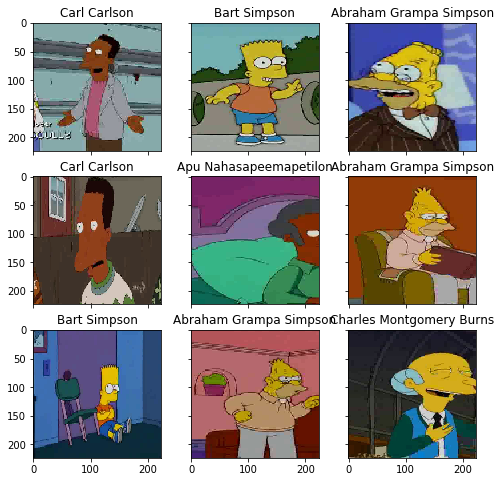

In [18]:
#Посмотреть на героев внутри датасета
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #Взял lr меньше, чем 10^-3, потому что не замораживал веса сверток, а обучал всю сеть
        #Большое значение имеет начальная инициализация весов модели.
        #Использование pretrained=True даёт нам значение весов, находящиеся ближе к минимуму функции ошибки,
        #Чем когда мы инициализируем нормальным распределением, или другими способами
        #Поэтому lr надо брать меньше
        opt = torch.optim.Adam(model.parameters(), lr = 0.00005, amsgrad = True)
        criterion = nn.CrossEntropyLoss()
        #С каждой 10 эпохой обучения lr уменьшается в 10 раз
        sheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 10, gamma = 0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            sheduler.step()
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
#количество классифицируемых объектов
n_classes = len(np.unique(train_val_labels))

In [0]:
#Класс-ансамбль моделей
class CNN_Ensamble(nn.Module):
  def __init__(self, modelA, modelB):
        super(CNN_Ensamble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier =  nn.Sequential(nn.Linear(n_classes * 2, 128),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.BatchNorm1d(128),
                           nn.Linear(128, n_classes))
        
  def forward(self, x):
       x1 = self.modelA(x)
       x2 = self.modelB(x)
       x = torch.cat((x1, x2), dim=1)
       x = self.classifier(x)
       return x

In [0]:
#Finetuning Resnet50
model_resnet50 = models.resnet50(pretrained=True) #Возьмём предобученную модель resnet50
#Переопределим классификатор(fc-слои)
model_resnet50.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(1000),
    nn.Linear(1000, 128),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(128),
    nn.Linear(128, n_classes)
)

In [26]:
#Если уже обучалась сеть, можно подключить имеющиеся веса
model_resnet50.load_state_dict(torch.load('gdrive/My Drive/model_resnet50final.pth'))

<All keys matched successfully>

In [27]:
#Положим модель на GPU 
model_resnet50.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
#Датасеты для обучения сети
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [37]:
history = train(new_train_dataset, val_dataset, model=model_resnet50, epochs=20, batch_size=128)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.082027649900623


epoch:   5%|▌         | 1/20 [04:06<1:18:08, 246.79s/it]


Epoch 001 train_loss: 2.0820     val_loss 1.8913 train_acc 0.8119 val_acc 0.9333
loss 0.6260533431474892


epoch:  10%|█         | 2/20 [08:08<1:13:34, 245.25s/it]


Epoch 002 train_loss: 0.6261     val_loss 0.2366 train_acc 0.9714 val_acc 0.9572
loss 0.13583141175947905


epoch:  15%|█▌        | 3/20 [12:08<1:09:04, 243.78s/it]


Epoch 003 train_loss: 0.1358     val_loss 0.1789 train_acc 0.9805 val_acc 0.9603
loss 0.08408241204632991


epoch:  20%|██        | 4/20 [16:09<1:04:46, 242.89s/it]


Epoch 004 train_loss: 0.0841     val_loss 0.1624 train_acc 0.9863 val_acc 0.9620
loss 0.06471950410605888


epoch:  25%|██▌       | 5/20 [20:09<1:00:31, 242.11s/it]


Epoch 005 train_loss: 0.0647     val_loss 0.1552 train_acc 0.9880 val_acc 0.9643
loss 0.05389170441076437


epoch:  30%|███       | 6/20 [24:10<56:23, 241.68s/it]


Epoch 006 train_loss: 0.0539     val_loss 0.1506 train_acc 0.9904 val_acc 0.9650
loss 0.04519164545864493


epoch:  35%|███▌      | 7/20 [28:11<52:17, 241.34s/it]


Epoch 007 train_loss: 0.0452     val_loss 0.1483 train_acc 0.9919 val_acc 0.9641
loss 0.04078094573742753


epoch:  40%|████      | 8/20 [32:11<48:12, 241.03s/it]


Epoch 008 train_loss: 0.0408     val_loss 0.1461 train_acc 0.9926 val_acc 0.9658
loss 0.03723235092924858


epoch:  45%|████▌     | 9/20 [36:13<44:13, 241.20s/it]


Epoch 009 train_loss: 0.0372     val_loss 0.1448 train_acc 0.9927 val_acc 0.9652
loss 0.03319164349544009


epoch:  50%|█████     | 10/20 [40:13<40:08, 240.86s/it]


Epoch 010 train_loss: 0.0332     val_loss 0.1440 train_acc 0.9940 val_acc 0.9664
loss 0.04054540004862346


epoch:  55%|█████▌    | 11/20 [44:12<36:03, 240.37s/it]


Epoch 011 train_loss: 0.0405     val_loss 0.1435 train_acc 0.9915 val_acc 0.9664
loss 0.037052452449140266


epoch:  60%|██████    | 12/20 [48:11<32:01, 240.14s/it]


Epoch 012 train_loss: 0.0371     val_loss 0.1430 train_acc 0.9932 val_acc 0.9671
loss 0.03850587356166397


epoch:  65%|██████▌   | 13/20 [52:11<28:00, 240.06s/it]


Epoch 013 train_loss: 0.0385     val_loss 0.1430 train_acc 0.9926 val_acc 0.9669
loss 0.037999538479736125


epoch:  70%|███████   | 14/20 [56:11<23:59, 239.90s/it]


Epoch 014 train_loss: 0.0380     val_loss 0.1429 train_acc 0.9920 val_acc 0.9673


KeyboardInterrupt: ignored

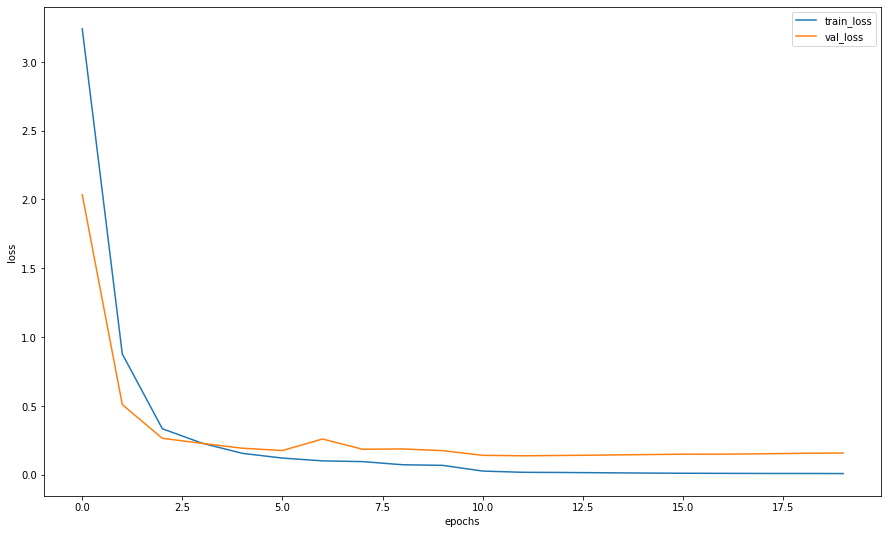

In [0]:
#Кривые обучения
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
#Можно сохранить веса натренированной модели
torch.save(model_resnet50.state_dict(), 'gdrive/My Drive/model_resnet50final.pth')

In [0]:
#Я еще тренировал resnet50 на неаугментированных картинках и сохранил веса. 
# Пробовал взять их ансамбль,но результат был таким что:
#У ансамбля train_acc = 0,89; а val_acc = 0,9503. Тут взял просто две модели resnet50. 
#Google colab не дал тренировать vgg16_bn сославшись на нехватку памяти

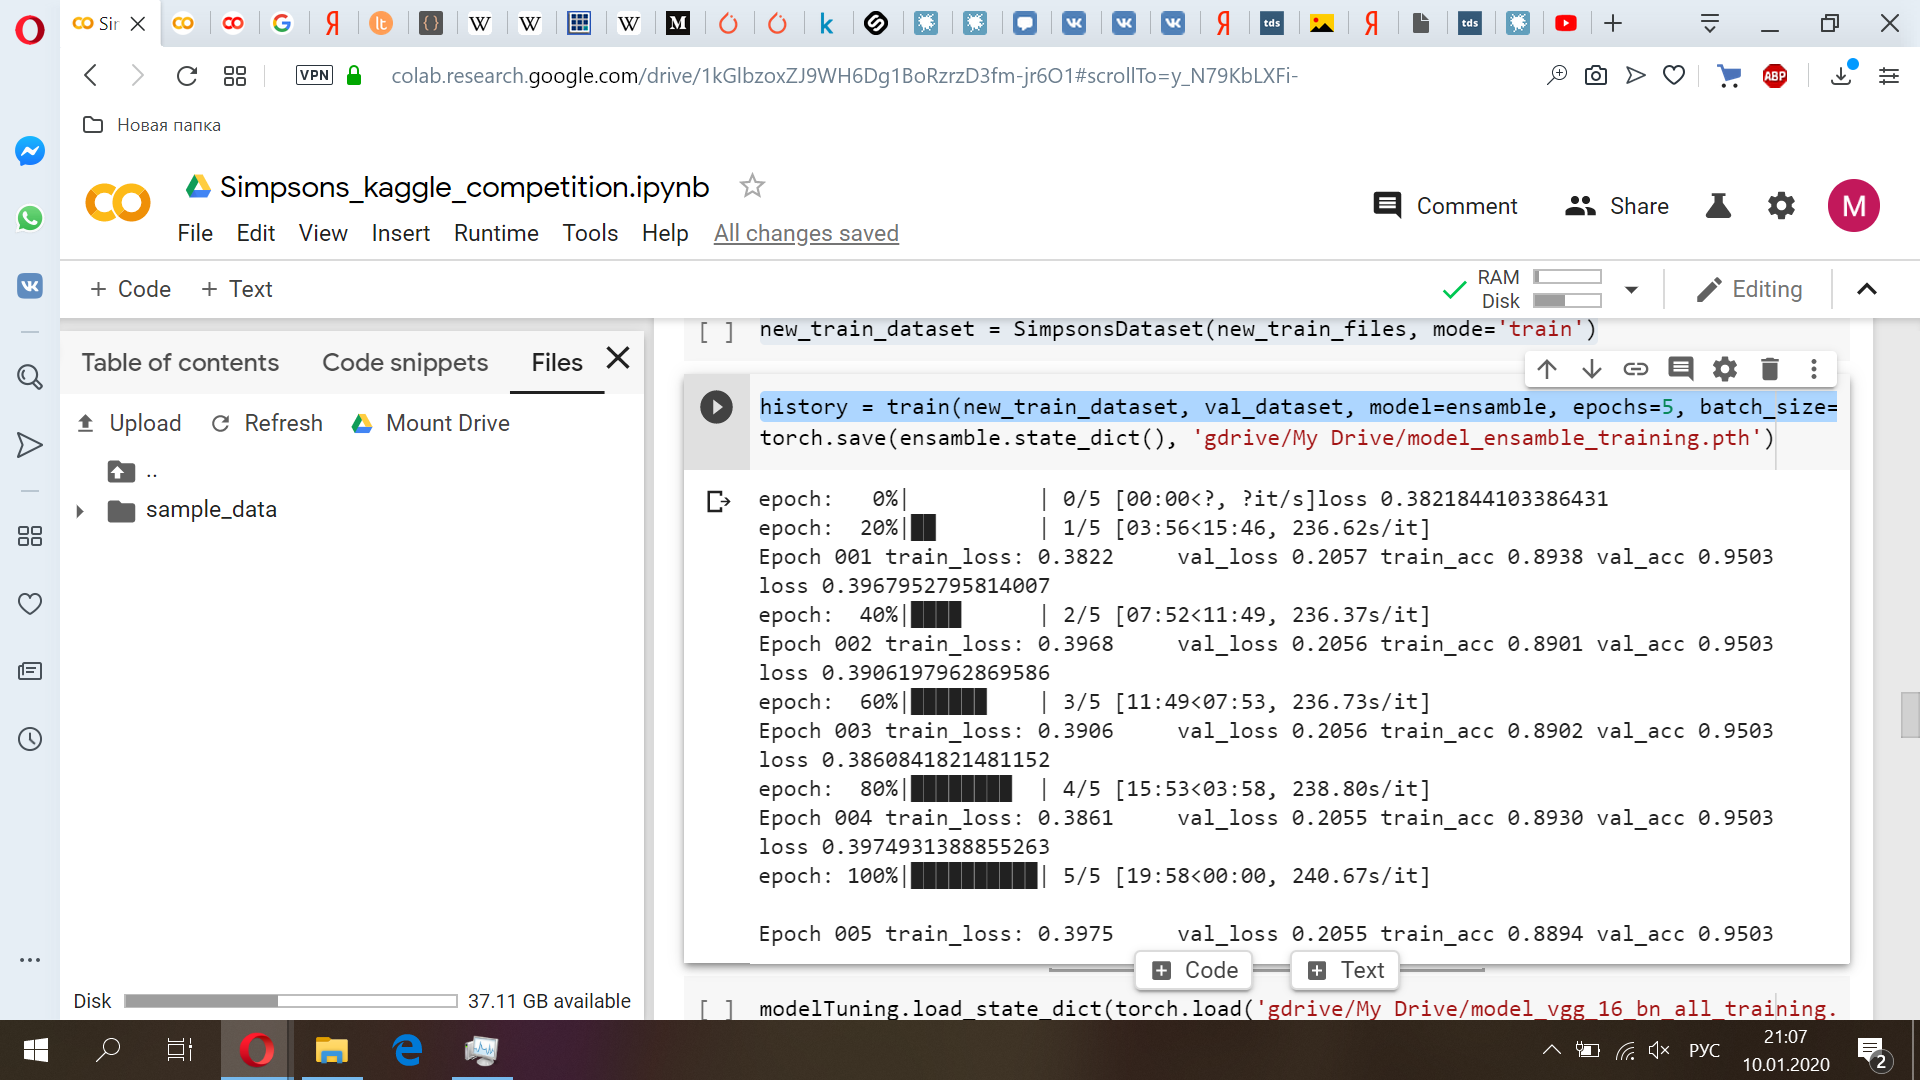

In [0]:
#Finetuning vgg16_bn
model_vgg16_bn = models.vgg16_bn(pretrained=True) #Возьмём предобученную модель vgg16_bn
#Переопределим классификатор
model_vgg16_bn.classifier = nn.Sequential(
    nn.Linear(25088, 128),
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.BatchNorm1d(128),
    nn.Linear(128, n_classes),
)

In [29]:
#Если уже обучалась сеть, можно подключить имеющиеся веса
model_vgg16_bn.load_state_dict(torch.load('gdrive/My Drive/vgg16_bn.pth'))

<All keys matched successfully>

In [0]:
for param in model_vgg16_bn.parameters():
  param.requires_grad = True
#Заморозим первый слои сети, чтобы сэкономить место на GPU (потом можно попробовать дообучить эти слои)
for param in model_vgg16_bn.features[0:12]:
  param.requires_grad_(requires_grad=False)

In [35]:
#Вывод параметров для обучения
params_to_update = []
for name,param in model_vgg16_bn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name, len(param))

	 features.14.weight 256
	 features.14.bias 256
	 features.15.weight 256
	 features.15.bias 256
	 features.17.weight 256
	 features.17.bias 256
	 features.18.weight 256
	 features.18.bias 256
	 features.20.weight 256
	 features.20.bias 256
	 features.21.weight 256
	 features.21.bias 256
	 features.24.weight 512
	 features.24.bias 512
	 features.25.weight 512
	 features.25.bias 512
	 features.27.weight 512
	 features.27.bias 512
	 features.28.weight 512
	 features.28.bias 512
	 features.30.weight 512
	 features.30.bias 512
	 features.31.weight 512
	 features.31.bias 512
	 features.34.weight 512
	 features.34.bias 512
	 features.35.weight 512
	 features.35.bias 512
	 features.37.weight 512
	 features.37.bias 512
	 features.38.weight 512
	 features.38.bias 512
	 features.40.weight 512
	 features.40.bias 512
	 features.41.weight 512
	 features.41.bias 512
	 classifier.0.weight 128
	 classifier.0.bias 128
	 classifier.3.weight 128
	 classifier.3.bias 128
	 classifier.4.weight 42
	 classifie

In [36]:
model_vgg16_bn.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [38]:
history = train(new_train_dataset, val_dataset, model=model_vgg16_bn, epochs=20, batch_size=128)
#Можно сохранить веса натренированной модели
torch.save(model_vgg16_bn.state_dict(), 'gdrive/My Drive/vgg16_bn.pth')

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.115891709374267


epoch:   5%|▌         | 1/20 [06:16<1:59:08, 376.25s/it]


Epoch 001 train_loss: 2.1159     val_loss 1.4454 train_acc 0.6733 val_acc 0.8410
loss 0.6439821366429082


epoch:  10%|█         | 2/20 [12:31<1:52:48, 376.01s/it]


Epoch 002 train_loss: 0.6440     val_loss 0.3827 train_acc 0.8400 val_acc 0.9028
loss 0.3014899227614938


epoch:  15%|█▌        | 3/20 [18:44<1:46:15, 375.00s/it]


Epoch 003 train_loss: 0.3015     val_loss 0.2898 train_acc 0.9234 val_acc 0.9241
loss 0.19556360837975068


epoch:  20%|██        | 4/20 [24:58<1:39:57, 374.85s/it]


Epoch 004 train_loss: 0.1956     val_loss 0.2646 train_acc 0.9499 val_acc 0.9318
loss 0.1457487967891713


epoch:  25%|██▌       | 5/20 [31:10<1:33:28, 373.92s/it]


Epoch 005 train_loss: 0.1457     val_loss 0.2668 train_acc 0.9626 val_acc 0.9303
loss 0.1277808001178385


epoch:  30%|███       | 6/20 [37:21<1:27:03, 373.13s/it]


Epoch 006 train_loss: 0.1278     val_loss 0.2457 train_acc 0.9666 val_acc 0.9400
loss 0.09074476974211208


epoch:  35%|███▌      | 7/20 [43:37<1:21:00, 373.90s/it]


Epoch 007 train_loss: 0.0907     val_loss 0.2187 train_acc 0.9756 val_acc 0.9446
loss 0.07685047949108367


epoch:  40%|████      | 8/20 [49:53<1:14:55, 374.62s/it]


Epoch 008 train_loss: 0.0769     val_loss 0.2266 train_acc 0.9788 val_acc 0.9482
loss 0.06916431165739925


epoch:  45%|████▌     | 9/20 [56:09<1:08:42, 374.80s/it]


Epoch 009 train_loss: 0.0692     val_loss 0.2305 train_acc 0.9824 val_acc 0.9486
loss 0.05222488358797636


epoch:  50%|█████     | 10/20 [1:02:24<1:02:29, 374.97s/it]


Epoch 010 train_loss: 0.0522     val_loss 0.2063 train_acc 0.9875 val_acc 0.9551
loss 0.025327564437922445


epoch:  55%|█████▌    | 11/20 [1:08:39<56:14, 374.93s/it]


Epoch 011 train_loss: 0.0253     val_loss 0.1828 train_acc 0.9931 val_acc 0.9601
loss 0.018239797252365676


epoch:  60%|██████    | 12/20 [1:14:50<49:50, 373.80s/it]


Epoch 012 train_loss: 0.0182     val_loss 0.1829 train_acc 0.9953 val_acc 0.9629
loss 0.018398429887200043


epoch:  65%|██████▌   | 13/20 [1:20:58<43:25, 372.20s/it]


Epoch 013 train_loss: 0.0184     val_loss 0.1825 train_acc 0.9956 val_acc 0.9624
loss 0.014621196170005376


epoch:  70%|███████   | 14/20 [1:27:09<37:09, 371.66s/it]


Epoch 014 train_loss: 0.0146     val_loss 0.1871 train_acc 0.9969 val_acc 0.9605
loss 0.011646499406694088


epoch:  75%|███████▌  | 15/20 [1:33:24<31:03, 372.70s/it]


Epoch 015 train_loss: 0.0116     val_loss 0.1810 train_acc 0.9978 val_acc 0.9645
loss 0.01169928758107203


epoch:  80%|████████  | 16/20 [1:39:40<24:55, 373.77s/it]


Epoch 016 train_loss: 0.0117     val_loss 0.1865 train_acc 0.9972 val_acc 0.9645
loss 0.01065579269280628


epoch:  85%|████████▌ | 17/20 [1:45:53<18:40, 373.40s/it]


Epoch 017 train_loss: 0.0107     val_loss 0.1897 train_acc 0.9975 val_acc 0.9633
loss 0.01073036287646916


epoch:  90%|█████████ | 18/20 [1:52:02<12:24, 372.03s/it]


Epoch 018 train_loss: 0.0107     val_loss 0.1931 train_acc 0.9975 val_acc 0.9624
loss 0.010218409879795146


epoch:  95%|█████████▌| 19/20 [1:58:10<06:10, 370.95s/it]


Epoch 019 train_loss: 0.0102     val_loss 0.1923 train_acc 0.9980 val_acc 0.9626
loss 0.00786518582012521


epoch: 100%|██████████| 20/20 [2:04:21<00:00, 370.84s/it]


Epoch 020 train_loss: 0.0079     val_loss 0.1966 train_acc 0.9984 val_acc 0.9620


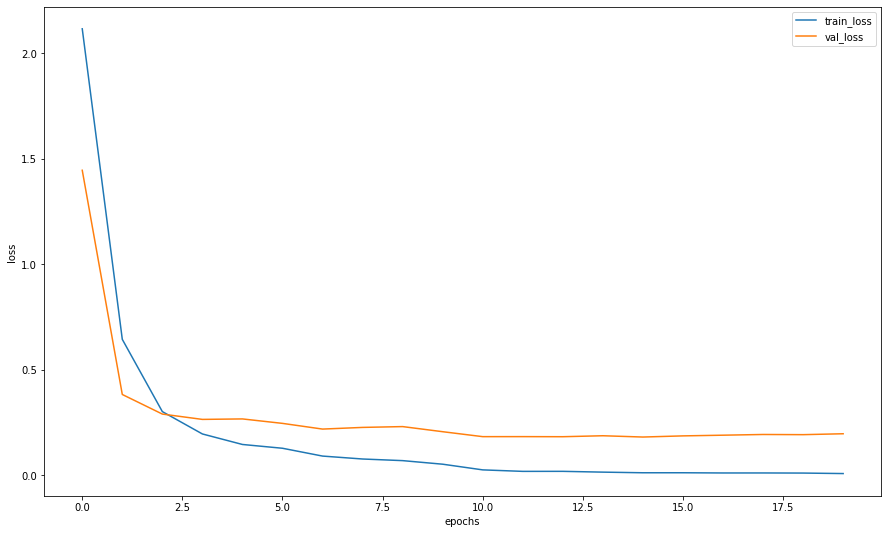

In [39]:
#Кривые обучения
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [35]:
for param in model_vgg16_bn.parameters():
  param.requires_grad_(requires_grad=True)
#Разморозим первые слои и попробуем доучить
for param in model_vgg16_bn.features[12:]:
  param.requires_grad_(requires_grad=False)
for param in model_vgg16_bn.classifier:
  param.requires_grad_(requires_grad=False)
#Вывод параметров для обучения
params_to_update = []
for name,param in model_vgg16_bn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name, len(param))


	 features.0.weight 64
	 features.0.bias 64
	 features.1.weight 64
	 features.1.bias 64
	 features.3.weight 64
	 features.3.bias 64
	 features.4.weight 64
	 features.4.bias 64
	 features.7.weight 128
	 features.7.bias 128
	 features.8.weight 128
	 features.8.bias 128
	 features.10.weight 128
	 features.10.bias 128
	 features.11.weight 128
	 features.11.bias 128


In [37]:
train(new_train_dataset, val_dataset, model=model_vgg16_bn, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: ignored

In [0]:
ensamble = CNN_Ensamble(model_resnet50, model_vgg16_bn)

In [31]:
#Будем обучать только классификатор ансамбля
for param in ensamble.parameters():#Замарозка всех параметров
  param.requires_grad = False
for param in ensamble.classifier.parameters():#Разморозка параметров классификатора ансамбля
  param.requires_grad = True
params_to_update = ensamble.parameters()
print("Parametrs to update:")
params_to_update = []
#Вывод параметров для обучения
for name,param in ensamble.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name, len(param))
      

Parametrs to update:
	 classifier.0.weight 128
	 classifier.0.bias 128
	 classifier.3.weight 128
	 classifier.3.bias 128
	 classifier.4.weight 42
	 classifier.4.bias 42


In [32]:
ensamble.to(DEVICE)

CNN_Ensamble(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [0]:
#Переопределил функцию train для ансамбля
def train_ensamble(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 0.001, amsgrad = True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [37]:
history = train_ensamble(new_train_dataset, val_dataset, model=ensamble, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

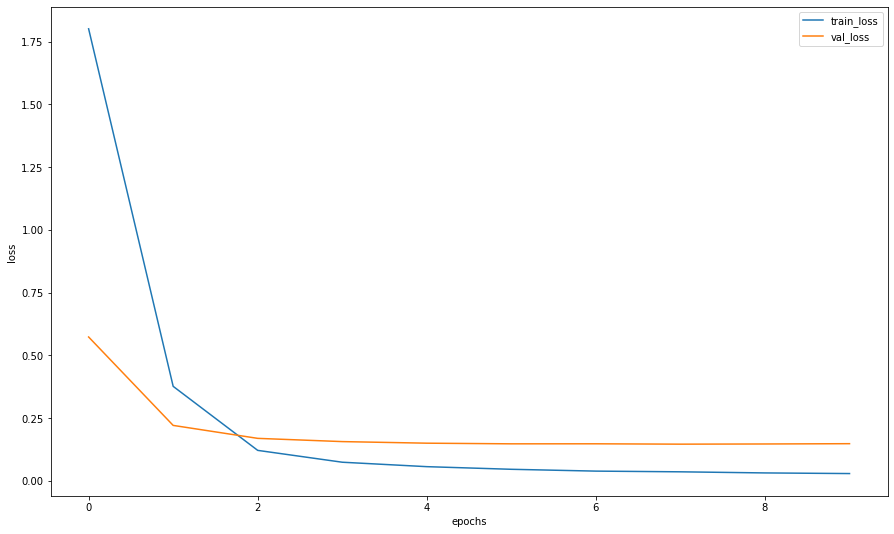

In [38]:
#Кривые обучения
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
#Можно сохранить веса ансамбля
torch.save(ensamble.state_dict(), 'gdrive/My Drive/model_ensamblefinal.pth')

Сделаем сабмит на kaggle


In [0]:
import pandas as pd

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model_resnet50, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

In [0]:
submit.to_csv('submission.csv', index=False)

In [0]:
# Сделаем submit
!kaggle competitions submit simpsons4 -f submission.csv -m "Yeah! I submit my file through the Google Colab!"